In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


In [34]:
data = pd.read_csv(r'D:\CloudWatch_Traffic_Web_Attack.csv')
print("Dataset Shape:", data.shape)
print("First 5 rows:\n", data.head())
print("Basic Info:\n", data.info())


Dataset Shape: (282, 16)
First 5 rows:
    bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0

In [35]:
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)
data['bytes_in'].fillna(data['bytes_in'].median(), inplace=True)
data.dropna(subset=['src_ip', 'dst_ip'], inplace=True)


Missing Values:
 bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


In [36]:
data['creation_time'] = pd.to_datetime(data['creation_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['time'] = pd.to_datetime(data['time'])


In [37]:
data['session_duration'] = (data['end_time'] - data['creation_time']).dt.total_seconds()

In [38]:
data['avg_packet_size'] = (data['bytes_in'] + data['bytes_out']) / data['session_duration'].replace(0, 1)


In [39]:
data['is_suspicious'] = (data['detection_types'] == 'Suspicious').astype(int)

In [40]:
protocol_data = data['protocol'].copy()  

In [41]:
num_features = ['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

In [42]:
cat_features = ['src_ip_country_code']  # protocol को अलग रखा
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(data[cat_features])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(cat_features))
data = pd.concat([data.drop(cat_features, axis=1), encoded_df], axis=1)


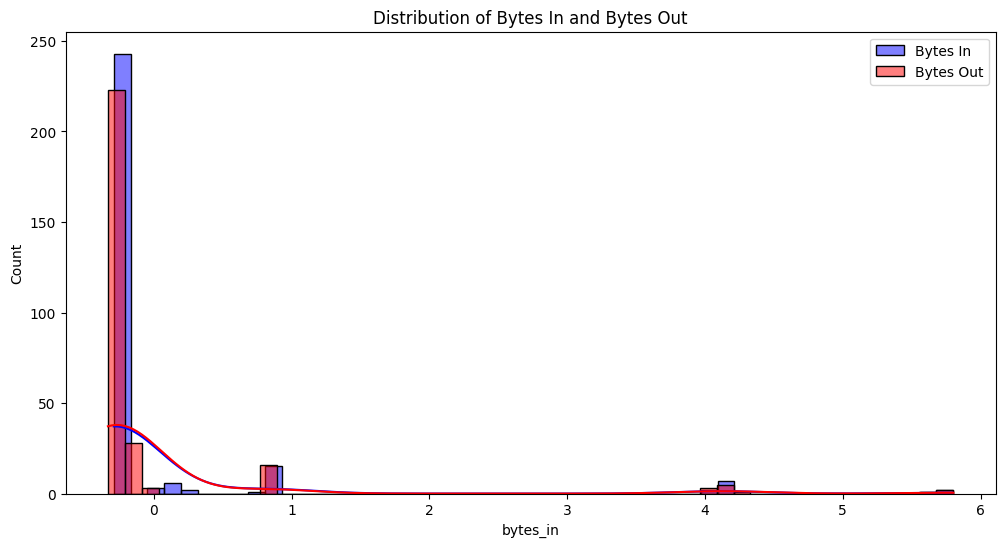

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(data['bytes_in'], bins=50, color='blue', kde=True, label='Bytes In')
sns.histplot(data['bytes_out'], bins=50, color='red', kde=True, label='Bytes Out')
plt.legend()
plt.title('Distribution of Bytes In and Bytes Out')
plt.savefig('bytes_distribution.png')
plt.show()

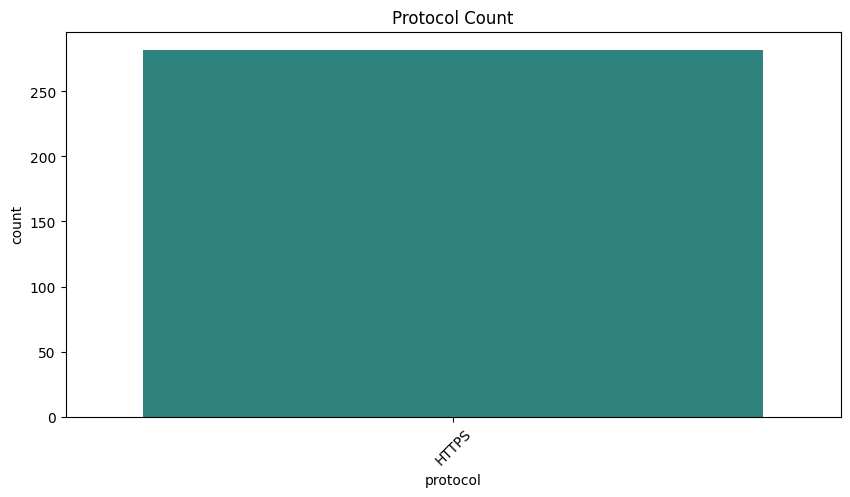

In [44]:
plt.figure(figsize=(10, 5))
sns.countplot(x=protocol_data, palette='viridis')  # ओरिजिनल protocol यूज
plt.title('Protocol Count')
plt.xticks(rotation=45)
plt.savefig('protocol_count.png')
plt.show()

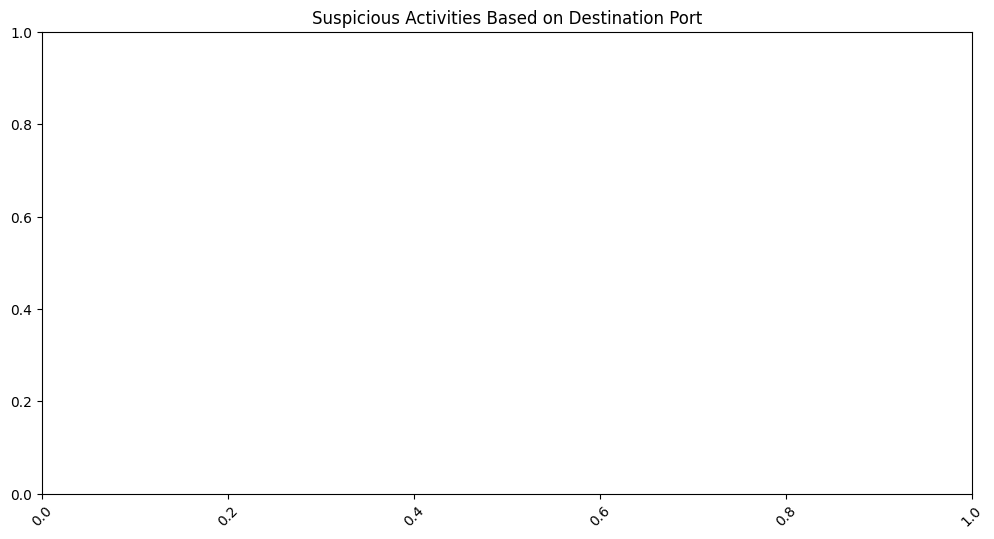

In [51]:
plt.figure(figsize=(12, 6))
sns.countplot(x='dst_port', data=data[data['detection_types'] == 'Suspicious'], palette='coolwarm')
plt.title('Suspicious Activities Based on Destination Port')
plt.xticks(rotation=45)
plt.savefig('suspicious_ports.png')
plt.show() 

In [52]:
features = data[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
model = IsolationForest(contamination=0.05, random_state=42)
data['anomaly'] = model.fit_predict(features)
data['anomaly'] = data['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

In [53]:
print("Anomaly Detection Results:\n", data['anomaly'].value_counts())
suspicious_activities = data[data['anomaly'] == 'Suspicious']
print("Suspicious Activities Samples:\n", suspicious_activities.head())

Anomaly Detection Results:
 anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64
Suspicious Activities Samples:
      bytes_in  bytes_out             creation_time                  end_time  \
36   0.722109   0.781614 2024-04-25 23:30:00+00:00 2024-04-25 23:40:00+00:00   
87   0.003912  -0.079349 2024-04-26 00:30:00+00:00 2024-04-26 00:40:00+00:00   
116  0.875890   0.870916 2024-04-26 01:00:00+00:00 2024-04-26 01:10:00+00:00   
132  0.166695  -0.197458 2024-04-26 01:20:00+00:00 2024-04-26 01:30:00+00:00   
153  0.886006   0.853511 2024-04-26 01:40:00+00:00 2024-04-26 01:50:00+00:00   

             src_ip protocol  response.code  dst_port        dst_ip  \
36    155.91.45.242    HTTPS            200       443  10.138.69.97   
87   165.225.240.79    HTTPS            200       443  10.138.69.97   
116   155.91.45.242    HTTPS            200       443  10.138.69.97   
132  165.225.240.79    HTTPS            200       443  10.138.69.97   
153   155.91.45.242    HTTPS      

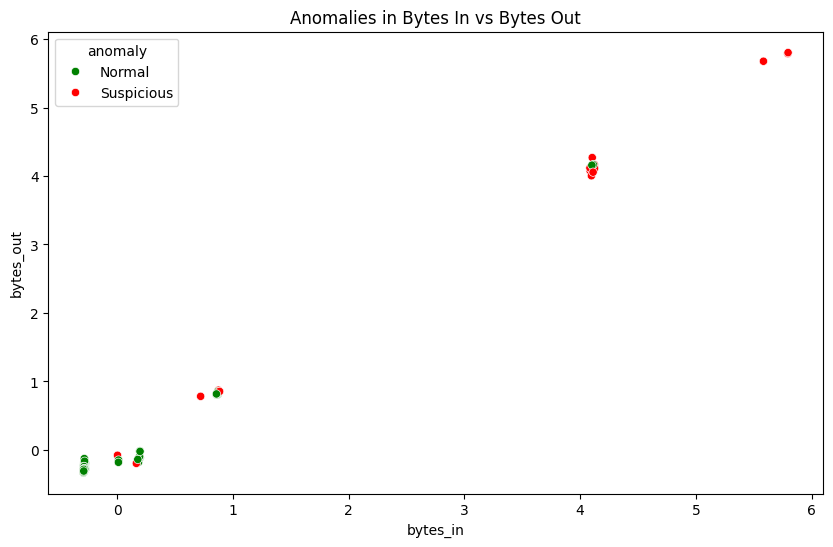

In [54]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=data, palette=['green', 'red'])
plt.title('Anomalies in Bytes In vs Bytes Out')
plt.savefig('anomaly_scatter.png')
plt.show()

In [56]:
X = data[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
y = data['is_suspicious']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [57]:
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.4204 - loss: 0.7007 - val_accuracy: 1.0000 - val_loss: 0.6358
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9873 - loss: 0.6262 - val_accuracy: 1.0000 - val_loss: 0.5565
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.5591 - val_accuracy: 1.0000 - val_loss: 0.4854
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.4899 - val_accuracy: 1.0000 - val_loss: 0.4175
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.4248 - val_accuracy: 1.0000 - val_loss: 0.3486
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 0.3495 - val_accuracy: 1.0000 - val_loss: 0.2792
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.2760 - val_accuracy: 1.0000 - val_loss: 0.2137
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.2128 - val_accuracy: 1.0000 - val_loss: 0.1558

In [58]:
loss, acc = model_nn.evaluate(X_test, y_test)
print(f"Neural Network Test Accuracy: {acc*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0824
Neural Network Test Accuracy: 100.00%


In [59]:
print("\nInsights:")
print("- High bytes_in and low bytes_out sessions could indicate possible infiltration attempts.")
print("- Frequent interactions from specific country codes may indicate targeted or bot-related attacks.")
print("- High activity on non-standard ports may signal unauthorized access attempts.") 



Insights:
- High bytes_in and low bytes_out sessions could indicate possible infiltration attempts.
- Frequent interactions from specific country codes may indicate targeted or bot-related attacks.
- High activity on non-standard ports may signal unauthorized access attempts.
